# Playing with Random Forests in League of Legends

This notebook contains the code to generate the figures found in the [post on my blog](http://www.trailofpapers.net/2015/10/playing-with-random-forests-in-league.html). Functions called by this notebook can be found on [github](http://github.com/map222/lolML). My summoner IDs are lemmingo and Umiy.

### Table of contents

[Querying Riot's API](#query)

[Explore data](#explore)

[Machine learning](#machine)

[Surrendered games](#surrender)

Load libraries and API key

In [11]:
import requests, json
import numpy as np
from src import API_io
import importlib
import pandas as pd
import os
import pickle
from src import feature_calc

In [2]:
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML'
os.chdir(working_dir)
with open(working_dir+ '\\api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

<a id='query'></a>
# Get summoner names, and list of matches

Load featured games, and get a list of summoner_names

In [34]:
featured_json = API_io.load_featured_games(api_key) # load json of featured games
featured_game_ids = [x['gameId'] for x in featured_json ] #  use list comprehension to get featured games; don't use this

Make a list of summoner names and summoner IDs from the featured JSON

In [37]:
summoner_names, summoner_IDs = API_io.get_summoners_IDs_from_featured_games(featured_json, api_key)
summoner_names[:5]

['ÅNTI', 'Fer Pitou', 'Royalx799', 'Xandertrax', 'KimJinHo']

Make a list of summoner ID urls to query RITO with, and then query them (this is rate limited to one query / 1.2 seconds to avoid overloading API).

In [ ]:
summoner_urls = [API_io.make_matchlist_url_summoner_ID(x, True, True, api_key) for x in summoner_IDs]
summoner_urls[:2]
match_histories = [API_io.get_limited_request(x) for x in summoner_urls ]

Extract the match ID from the match history JSON

In [ ]:
match_IDs = np.empty(0, dtype=int)
for cur_matches in match_histories:
    match_IDs = np.append( match_IDs, [x['matchId'] for x in cur_matches['matches']] )
pd.Series(match_IDs).to_csv('Match IDs.csv')
match_IDs.shape

Load a csv of match infor if you have it saved from a previous time.

In [66]:
match_df = pd.read_csv('Match IDs.csv', header =None)
match_IDs = match_df[1]
match_IDs = match_IDs.unique()
match_IDs.shape

(27928,)

## Query Riot's API for individual game info

Make a list of match urls, and then use requests to query them; again this is rate limited.

In [67]:
# make urls for loading
match_urls = [API_io.make_match_info_url(x, True, api_key) for x in match_IDs] # True flag means we get the timeline
match_urls[:2]

['https://na.api.pvp.net/api/lol/na/v2.2/match/1955239698?includeTimeline=true&api_key=0da3703d-7bf5-4e72-96cd-5062b28720d7',
 'https://na.api.pvp.net/api/lol/na/v2.2/match/1954974642?includeTimeline=true&api_key=0da3703d-7bf5-4e72-96cd-5062b28720d7']

In [ ]:
import time
import sys
match_range = np.arange(2000,2010)
# this for loop is ugly; used list comprehension previously, but rate limit was fluky
full_match_info = np.empty(0)
for cur_match in match_range:
    time.sleep(1.2) # RIOT API is throttled to ~0.83 requests / second
    try:
        full_match_info = np.append(full_match_info, requests.get(match_urls[cur_match]).json() )
    except requests.exceptions.HTTPError as e:
        print('Error: ' + e + ' in game ' + str(match_IDs[cur_match]))
    except:
        err = sys.exc_info()[0]
        print('Error: ' + str(err) + ' in game ' + str(match_IDs[cur_match]))

Save to a JSON or .pickle so we don't have to query again.

In [ ]:
with open('full matchinfo.csv', 'w') as out_file:
    json.dump(full_match_info.tolist(), out_file)

In [10]:
# saving as a pickle file saves ~%40 of the space
pickle_name = 'full match info.pickle'
if not os.sys.isfile(pickle_name): # make sure you don't overwrite a file
    with open(pickle_name, 'wb') as pickle_file:
        pickle.dump(full_match_info, pickle_file)

## Load information from local JSON or pickle

If you already ran the above code and have some data saved, you can load it directly

In [6]:
# load from JSON
with open('games 6000-8000.json') as json_file:
    scraped_matches= json.load(json_file)
scraped_matches = np.array(full_match_info)

In [3]:
# loading the pickle in
with open('full match info.pickle', 'rb') as pickle_file:
    full_match_info = pickle.load(pickle_file)

# Analyze game data
<a id='explore'></a>
## Explore and clean data

First, load some more libraries


In [9]:
import matplotlib.pyplot as plt
import src.plotting as lol_plt
%matplotlib inline

Plot the length of games

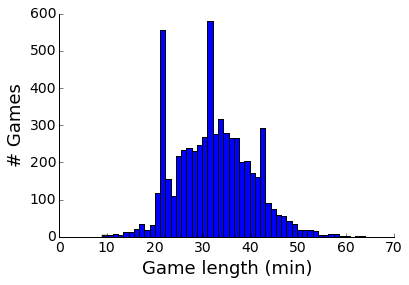

In [5]:
game_lengths = np.array([np.size(x['timeline']['frames']) for x in full_match_info] )
plt.hist(game_lengths, bins = 50);
plt.xlabel('Game length (min)', fontsize = 18)
plt.ylabel('# Games', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Some games don't even last twenty minutes! There is also a large spike of games ending around 20 minutes due to surrenders. When we create features, the feature calculator will have to consider game length.

## Create features

Create features for the classifier; now just starting with simple stuff like first blood, first tower, and first dragon.

In [24]:
importlib.reload(feature_calc)
games_df = feature_calc.calc_features_all_matches(full_match_info, 20)
games_df.head(3)

,first_dragon,drag_diff,total_drag,first_baron,blue_barons,red_barons,first_tower,tower_diff,total_tower,first_inhib,...,blue_3,blue_4,red_0,red_1,red_2,red_3,red_4,surrender,game_length,winner
matchId,,,,,,,,,,,,,,,,,,,,,
1955239698,1,1,3,1,1,0,1,1,9,-1,...,59,429,82,1,2,86,201,1,37,1
1954974642,0,-3,3,0,0,1,0,-7,9,0,...,20,22,56,432,67,101,39,1,32,0
1950969271,0,0,2,0,0,1,0,0,6,-1,...,60,267,201,238,223,119,150,0,44,0


In [25]:
games_df.dtypes

first_dragon    category
drag_diff        float64
total_drag       float64
first_baron     category
blue_barons      float64
red_barons       float64
first_tower     category
tower_diff       float64
total_tower      float64
first_inhib     category
blue_inhibs      float64
red_inhibs       float64
first_blood     category
gold_diff        float64
kill_diff        float64
total_kill       float64
blue_share       float64
red_share        float64
blue_0           float64
blue_1           float64
blue_2           float64
blue_3           float64
blue_4           float64
red_0            float64
red_1            float64
red_2            float64
red_3            float64
red_4            float64
surrender       category
game_length      float64
winner          category
dtype: object

The gold difference forms a pretty nice normal distribution.

Standard deviation of gold difference: 8019


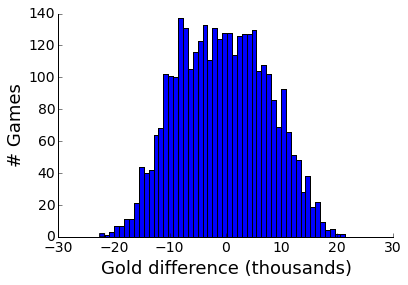

In [26]:
count, bins, _ = plt.hist(np.array(games_df['gold_diff']) / 1000, bins = 50)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference (thousands)', fontsize = 18)
lol_plt.prettify_axes(plt.gca())
print('Standard deviation of gold difference: {:.0f}'.format(games_df['gold_diff'].std()))

Both teams have similar amounts of kills.

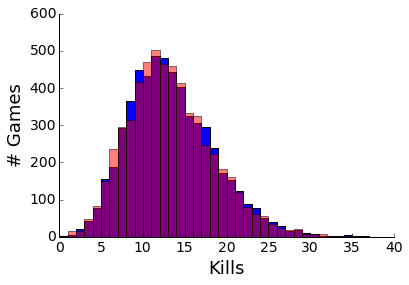

In [41]:
bins = np.arange(40)
kills_fig = plt.figure()
plt.hist(games_df['blue_kills'] , bins = bins, color = 'blue')
plt.hist(games_df['red_kills'] , bins = bins, color = 'red', alpha = 0.5)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kills', fontsize = 18)
lol_plt.prettify_axes(plt.gca())
#plt.gca().set_xticklabels(bins / 1000, rotation = 90)

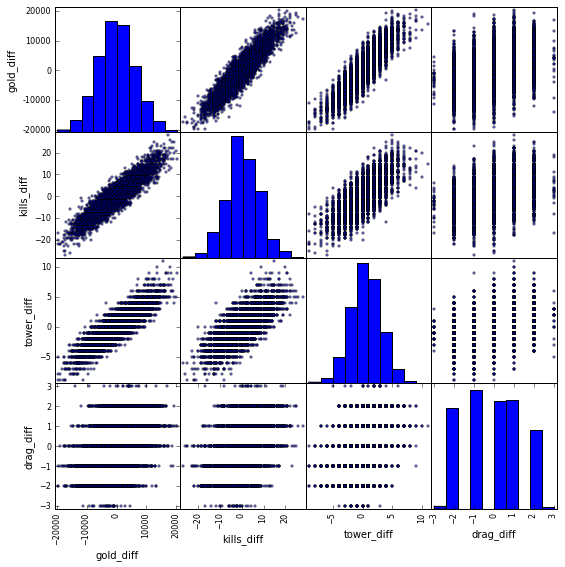

In [68]:
pd.tools.plotting.scatter_matrix(games_df[['gold_diff', 'kills_diff', 'tower_diff', 'drag_diff']], figsize = [9, 9]);

As one might expect, there is a lot of multicollinearity between all the variables. This would make running linear regression more difficult, but I am going to use a Random Forest, for which that is less problematic.

<a id='machine'></a>
# Run machine learning algorithms: 
## Load libraries, and initialize feature info

In [6]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [18]:
# variables for classifiers
col_names = feature_calc.col_names
train_col = np.array([x for x in col_names if x not in
             ['winner', 'game_length', 'blue_0', 'blue_1', 'blue_2', 'blue_3', 'blue_4',
              'red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'matchId'] ])
num_features = np.size(train_col)
print(train_col, )

['first_dragon' 'drag_diff' 'total_drag' 'first_baron' 'blue_barons'
 'red_barons' 'first_tower' 'tower_diff' 'total_tower' 'first_inhib'
 'blue_inhibs' 'red_inhibs' 'first_blood' 'gold_diff' 'kill_diff'
 'total_kill' 'blue_share' 'red_share' 'surrender']


## Naive Bayes:

First let's see how good prediction is with each feature individually

In [30]:
gnb = GaussianNB()
def quick_score(games_df, col_index):
    gnb.fit(games_df[[col_index]], games_df['winner'])
    return gnb.score(games_df[[col_index]], games_df['winner'])

scores = [quick_score(games_df, x) for x in np.arange(num_features-1)]
[x for x in list(zip(train_col, scores))]

[('first_dragon', 0.61394410832613078),
 ('drag_diff', 0.69288389513108617),
 ('total_drag', 0.52607317775857099),
 ('first_baron', 0.66580236243157587),
 ('blue_barons', 0.66810717372515127),
 ('red_barons', 0.6698357821953328),
 ('first_tower', 0.58081244598098536),
 ('tower_diff', 0.75569000288101407),
 ('total_tower', 0.52434456928838946),
 ('first_inhib', 0.66493805819648522),
 ('blue_inhibs', 0.66493805819648522),
 ('red_inhibs', 0.62057044079515988),
 ('first_blood', 0.54335926246038602),
 ('gold_diff', 0.82541054451166807),
 ('kill_diff', 0.76692595793719387),
 ('total_kill', 0.52607317775857099),
 ('blue_share', 0.52607317775857099),
 ('red_share', 0.53673292999135691)]

Here, we can already see some features like gold_diff and kills_diff are important, while others like first_blood are less informative. We can put them all together if we design the Naive Bayes classifier correctly, but let's skip ahead to random forests.

## Random Forest Feature Importance

Let's first start by figuring out which features are important with a large random forest. First, let's get a dataframe for each timepoint

In [15]:
timeline_end = 50
time_indices = np.arange(5, timeline_end, 5)
timelines_df = [feature_calc.calc_features_all_matches(full_match_info, x) for x in time_indices]
print([x.shape[0] for x in timelines_df])

[5995, 5991, 5948, 5800, 4684, 3471, 2019, 912, 294]


Create a large forest so we can better identify important features

In [16]:
big_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 100, max_features = 'sqrt')

In [19]:
importances = std = np.zeros([len(timelines_df), np.size(train_col)])
for i, cur_df in enumerate(timelines_df):
    big_forest.fit(cur_df[train_col], cur_df['winner'])
    importances[i] = big_forest.feature_importances_
    std[i] = np.std([tree.feature_importances_ for tree in big_forest.estimators_],
                 axis=0)
indices_at_20 = np.argsort(importances[3])[::-1]
indices_at_35 = np.argsort(importances[6])[::-1]

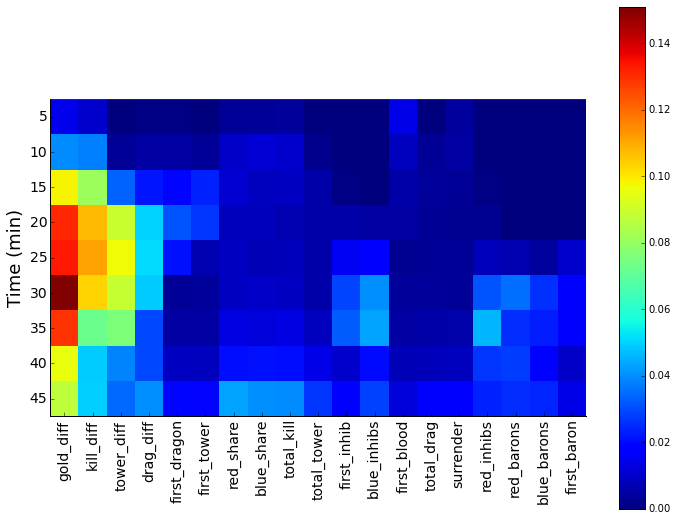

In [20]:
feature_fig = plt.figure(figsize = [12,9])
plt.imshow(importances[:,indices_at_20], interpolation = 'none', extent = [0, num_features*4, 47.5, 2.5])
plt.ylabel('Time (min)', fontsize = 18)
plt.xticks(np.arange(0, num_features*4, 4)+2, indices_at_20)
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
lol_plt.prettify_axes(plt.gca())
plt.gca().yaxis.set_ticks(time_indices);
plt.colorbar();

Gold differential is the most important feature at all timepoints, followed by kill differential, and tower differential. Dragon differential comes in late, behind the total number of towers, at #6. Barons and inhibitors are not particularly informative at later timepoints, probably because they are a reflection of gold and kill differentials.

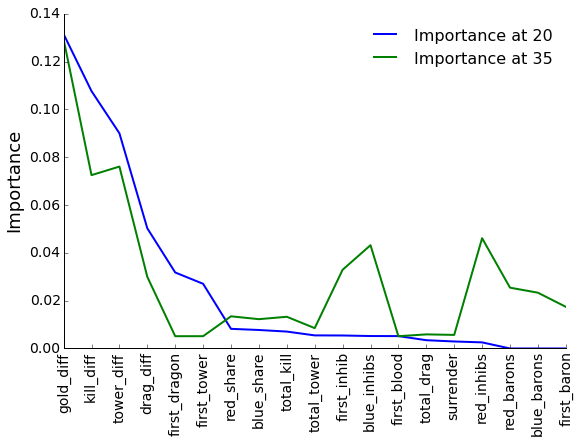

In [21]:
plt.figure(figsize = [9, 6])
plt.plot(importances[3,indices_at_20], label = 'Importance at 20', linewidth = 2)
plt.plot(importances[6,indices_at_20], label = 'Importance at 35', linewidth = 2)
plt.ylabel('Importance', fontsize = 18)
plt.xticks(np.arange(num_features))
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
plt.legend(frameon = False, fontsize = 16)
lol_plt.prettify_axes(plt.gca())

Let's extract the important columns for future analyses

In [25]:
import_at_20 = train_col[indices_at_20[:7]]
import_at_35 = train_col[indices_at_35[:9]]
important_col = np.unique(np.append(import_at_20, import_at_35))
important_col

array(['blue_barons', 'blue_inhibs', 'drag_diff', 'first_dragon',
       'first_inhib', 'first_tower', 'gold_diff', 'kill_diff',
       'red_barons', 'red_inhibs', 'red_share', 'tower_diff'], 
      dtype='<U12')

## Does game get more predictable over time?

Now that we have features that are important, we can answer other questions.

In [26]:
rfc = RandomForestClassifier(n_jobs = 2, n_estimators = 20, max_features = 'sqrt')
def cross_validate_df(cur_df):
    return cross_validation.cross_val_score(rfc, cur_df[important_col], cur_df['winner'], cv=5, n_jobs = 2)

scores_list = [cross_validate_df(x) for x in timelines_df]

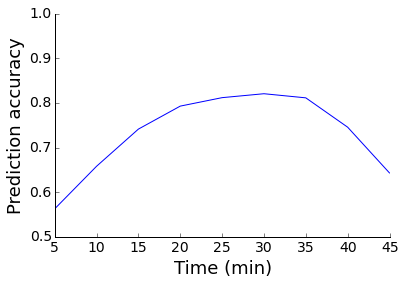

In [27]:
plt.plot(time_indices, np.mean(scores_list, 1))
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())

The game does get more easily predicted with time, as more information is gathered by the model. However, once you reach 30 minutes, the model loses accuracy. This is probably because as the game enters the late phase, gold matters less, and objectives more, and a single decisive teamfight can decide the game either way.

<a id='surrender'></a>
## Are surrendered games winnable?

First, separate games into surrendered early, and those that were semi-close.

In [28]:
surrender_at_20_df = timelines_df[3].query('(surrender == 1) & (game_length <=25)')
good_games_df = timelines_df[3].query('(surrender == 0) | (game_length >25)')
surrender_at_20_df[['surrender', 'game_length']].head(2)

,surrender,game_length
matchId,,
1947508622,1,22
1947379227,1,25


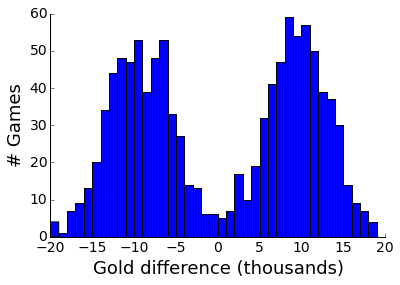

In [29]:
gold_bins = np.arange(-20, 20)
plt.hist(np.array(surrender_at_20_df['gold_diff']) / 1000, bins=gold_bins)
plt.xlabel('Gold difference (thousands)', fontsize = 18)
plt.ylabel('# Games', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Since these are stomps, the gold difference is bimodal towards large leads. However, there are a few games with small gold leads. First, let's see how accurate the random forest is for these stomps. (It should be high!)

In [30]:
surrender_forest = RandomForestClassifier(n_jobs = 2, n_estimators = 10, max_features = 'sqrt')
surrender_scores = cross_validation.cross_val_score(surrender_forest, surrender_at_20_df[important_col], surrender_at_20_df['winner'], cv=10)
print('Forest mean accuracy for surrendered games: {:.2f}'.format(np.mean(surrender_scores)))

Forest mean accuracy for surrendered games: 0.99


Pretty damn good! Ok, what happens if we train the model on the "close" games, and use it to predict the probability of winning surrendered ones?

In [31]:
close_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 20, max_features = 'sqrt')
close_forest.fit(good_games_df[important_col], good_games_df['winner'])
cross_score = np.mean(np.max(close_forest.predict_proba(surrender_at_20_df[important_col]), axis = 1))
print('A forest trained on non-surrender games predicts the team that won would do so with {:.2f} probability'.format(cross_score))

A forest trained on non-surrender games predicts the team that won would do so with 0.94 probability


The random forest trained on close games actually gives games surrendered at 20 a 6% chance of winning!